In [ ]:
import json
import os
from typing import List
import ast
import nltk
import torch
import pandas as pd
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import bert_score
import functools
import networkx as nx
from pyrouge import Rouge155
import time
import shutil
import numpy as np
import nltk
from simcse import SimCSE
import argparse
from scipy import spatial
from sentence_transformers import SentenceTransformer

from IPython.utils import io
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("DUC2004.csv",encoding="latin-1")

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
summarizer_lsa = LsaSummarizer()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def generate_summary(heu):
  # for heu in dataset['heuristic1']:
    # print("Original Text:", heu)
    # print("Original Summary:", abs)
    parser = PlaintextParser.from_string(heu, Tokenizer('english'))
    summary= summarizer_lsa(parser.document, 6)
    lex_summary=""

    for sentence in summary:
        lex_summary+=str(sentence)
    return lex_summary
    # print("Predicted Summary:", lex_summary)
    # print("\n")

# dataset['LSA_summary']=dataset['new_heuristic'].apply(lambda x:generate_summary(x))

In [ ]:
ref_sum = "4"
ground_summary_list = []
gen_summary_list=[]
for index, row in df.iterrows():
    print(index)
    doc_list=[]
    for file in os.listdir(row["documents"]):
        with open(row["documents"]+file) as f:
            doc_list = doc_list+(f.readlines())
    full_doc= (' '.join(doc_list)).replace('\n','')
    gen_summary_list.append(generate_summary(full_doc))

    with open(row["summary"]+ref_sum+".txt") as f1:
        gsum=(' '.join(f1.readlines())).replace('\n','')
        ground_summary_list.append(gsum)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
print("Predicted Summary:",gen_summary_list[1])
print("ground_Truth_summary:",ground_summary_list[1])

Predicted Summary: Hunter dismissed the league's latest proposal on Friday afternoon,  then said both sides would be best served by awaiting Feerick's ruling.With wide philosophical differences on how $2 billion  annual income should be distributed, both sides have privately said  they don't expect to play a regular season game before December.Fordham Law School dean John Feerick will rule whether or not more  than 200 players with $800 million in guaranteed contracts should  be paid during the lockout.A league  official said the games would be canceled in blocks of one or two  weeks, depending upon circumstances regarding negotiations.The union argued  that owners should have protected themselves by inserting clauses  about non-payment for lockouts and strikes into individual player  contracts.If Feerick finds in favor of the players, there  will be no economic incentive for those with guaranteed contracts  to reach an agreement quickly.
ground_Truth_summary: In a dispute between the 

In [ ]:
def test_rouge(predicted_summaries, gold_summaries):
    """Calculate ROUGE scores of sequences passed as an iterator
       e.g. a list of str, an open file, StringIO or even sys.stdin
    """
    current_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
    tmp_dir = ".rouge-tmp-{}".format(current_time)
    try:
        if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
            os.mkdir(tmp_dir + "/candidate")
            os.mkdir(tmp_dir + "/reference")
        print('preparing predicted summaries')
        candidates = [line.strip() for line in tqdm(predicted_summaries,total=len(predicted_summaries))]
        print('preparing gold summaries')
        gold = [line.strip() for line in tqdm(gold_summaries,total=len(gold_summaries))]
        assert len(candidates) == len(gold)
        cnt = len(candidates)
        print('Writing temp files')
        for i in tqdm(range(cnt)):
            if len(gold[i]) < 1:
                continue
            with open(tmp_dir + "/candidate/cand.{}.txt".format(i), "w",
                      encoding="utf-8") as f:
                f.write(candidates[i])
            with open(tmp_dir + "/reference/ref.{}.txt".format(i), "w",
                      encoding="utf-8") as f:
                f.write(gold[i])
        print("Doing ROUGE calculation")
        with io.capture_output() as captured:
            r = Rouge155()
            r.model_dir = tmp_dir + "/reference/"
            r.system_dir = tmp_dir + "/candidate/"
            r.model_filename_pattern = 'ref.#ID#.txt'
            r.system_filename_pattern = r'cand.(\d+).txt'
            rouge_results = r.convert_and_evaluate()
            results_dict = r.output_to_dict(rouge_results)
        return results_dict
    finally:
        pass
        if os.path.isdir(tmp_dir):
            shutil.rmtree(tmp_dir)


In [ ]:
def format_rouge_results(results):
    # return f"ROUGE-F(1/2/l)/ROUGE-R(1/2/l)/ROUGE-P(1/2/l): {results['rouge_1_f_score']}/{results['rouge_2_f_score']}/{results['rouge_l_f_score']} /{results['rouge_1_recall']}/{results['rouge_2_recall']}/{results['rouge_l_recall']} /{results['rouge_1_precision']}/{results['rouge_2_precision']}/{results['rouge_l_precision']}"
    # return f"ROUGE-F(1/2/l)/ROUGE-R(1/2/l): {results['rouge_1_f_score']}/{results['rouge_2_f_score']}/{results['rouge_l_f_score']} /{results['rouge_1_recall']}/{results['rouge_2_recall']}/{results['rouge_l_recall']}"
    return f"ROUGE-F(1/2/l/3/4/s*/su*)/ROUGE-R(1/2/l)/ROUGE-P(1/2/l): {results['rouge_1_f_score']}/{results['rouge_2_f_score']}/{results['rouge_l_f_score']}/{results['rouge_3_f_score']}/{results['rouge_4_f_score']}/{results['rouge_s*_f_score']}/{results['rouge_su*_f_score']} /{results['rouge_1_recall']}/{results['rouge_2_recall']}/{results['rouge_l_recall']} /{results['rouge_1_precision']}/{results['rouge_2_precision']}/{results['rouge_l_precision']}"

In [ ]:
our_pred = test_rouge(gen_summary_list,ground_summary_list)

preparing predicted summaries


100%|██████████| 50/50 [00:00<00:00, 381300.36it/s]


preparing gold summaries


100%|██████████| 50/50 [00:00<00:00, 381300.36it/s]


Writing temp files


100%|██████████| 50/50 [00:00<00:00, 3810.09it/s]
INFO:global:Writing summaries.
INFO:global:Processing summaries. Saving system files to /tmp/tmpe02ysdeu/system and model files to /tmp/tmpe02ysdeu/model.
INFO:global:Processing files in .rouge-tmp-2022-09-27-19-17-30/candidate/.
INFO:global:Processing cand.29.txt.
INFO:global:Processing cand.44.txt.
INFO:global:Processing cand.20.txt.
INFO:global:Processing cand.48.txt.
INFO:global:Processing cand.9.txt.
INFO:global:Processing cand.15.txt.
INFO:global:Processing cand.47.txt.
INFO:global:Processing cand.8.txt.
INFO:global:Processing cand.49.txt.
INFO:global:Processing cand.35.txt.
INFO:global:Processing cand.0.txt.
INFO:global:Processing cand.6.txt.
INFO:global:Processing cand.18.txt.
INFO:global:Processing cand.42.txt.
INFO:global:Processing cand.33.txt.
INFO:global:Processing cand.34.txt.
INFO:global:Processing cand.13.txt.
INFO:global:Processing cand.26.txt.
INFO:global:Processing cand.43.txt.
INFO:global:Processing cand.32.txt.
INFO

Doing ROUGE calculation


INFO:global:Processing ref.33.txt.
INFO:global:Processing ref.5.txt.
INFO:global:Processing ref.28.txt.
INFO:global:Processing ref.14.txt.
INFO:global:Processing ref.44.txt.
INFO:global:Processing ref.36.txt.
INFO:global:Processing ref.8.txt.
INFO:global:Processing ref.15.txt.
INFO:global:Processing ref.47.txt.
INFO:global:Processing ref.46.txt.
INFO:global:Processing ref.2.txt.
INFO:global:Processing ref.32.txt.
INFO:global:Processing ref.13.txt.
INFO:global:Processing ref.4.txt.
INFO:global:Processing ref.25.txt.
INFO:global:Processing ref.24.txt.
INFO:global:Processing ref.6.txt.
INFO:global:Processing ref.34.txt.
INFO:global:Processing ref.48.txt.
INFO:global:Processing ref.29.txt.
INFO:global:Processing ref.19.txt.
INFO:global:Processing ref.39.txt.
INFO:global:Processing ref.49.txt.
INFO:global:Processing ref.42.txt.
INFO:global:Saved processed files to /tmp/tmpe02ysdeu/model.
INFO:global:Written ROUGE configuration to /tmp/tmpl7f6f8_c/rouge_conf.xml
INFO:global:Running ROUGE wit

In [ ]:
format_rouge_results(our_pred)

'ROUGE-F(1/2/l/3/4/s*/su*)/ROUGE-R(1/2/l)/ROUGE-P(1/2/l): 0.28457/0.03598/0.13429/0.00834/0.00247/0.07006/0.07312 /0.35442/0.04487/0.16732 /0.23885/0.03018/0.11269'

In [ ]:
!pip3 install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge
rouge = Rouge()
rouge.get_scores(dataset['LSA_summary'], dataset['abstract'], avg=True)
# print(Scores)

{'rouge-1': {'f': 0.2613875234101277,
  'p': 0.24665419150162882,
  'r': 0.2986341173219435},
 'rouge-2': {'f': 0.07573977365221242,
  'p': 0.07376437399565818,
  'r': 0.085254329291578},
 'rouge-l': {'f': 0.23463420396423293,
  'p': 0.22167455940541128,
  'r': 0.2676419790260621}}

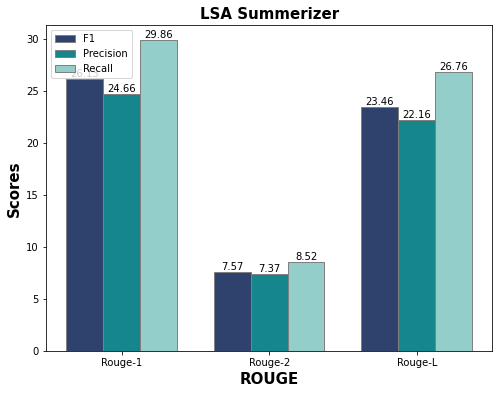

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 6))

# set height of bar
F1 = [26.13, 7.57, 23.46]
Precision = [24.66, 7.37, 22.16]
Recall = [29.86, 8.52, 26.76]
# Set position of bar on X axis
br1 = np.arange(len(F1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, F1, color ='#2F416D', width = barWidth,
        edgecolor ='grey', label ='F1')
plt.bar(br2, Precision, color ='#14868C', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, Recall, color ='#94CECA', width = barWidth,
        edgecolor ='grey', label ='Recall')


# Adding Xticks
plt.title('LSA Summerizer', fontweight ='bold', fontsize = 15)
plt.xlabel('ROUGE', fontweight ='bold', fontsize = 15)
plt.ylabel('Scores', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(F1))],
        ['Rouge-1', 'Rouge-2', 'Rouge-L'])

def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]+.25, y[i], ha='center')


def addlabels1(x, y):
    for i in range(len(x)):
        plt.text(i+0.25, y[i]+.25, y[i], ha='center')

def addlabels2(x, y):
    for i in range(len(x)):
        plt.text(i + .50, y[i]+.25, y[i], ha='center')


addlabels(br1, F1)
addlabels1(br2, Precision)
addlabels2(br3, Recall)

plt.legend()
plt.show()

In [ ]:
for i in range(0,10):
    print("Original text:",dataset['heuristic1'][i])
    print("Original summary:",dataset['abstract'][i])
    print("Predicted summary:",dataset['LSA_summary'][i])
    print("\n")

Original text: There is growing evidence that any strategy to effectively fight COVID-19 requires an efficient tracing of all contacts of infected individuals. Recent studies conclude that manual tracing is not fast enough and recommend the use of digital contact tracing systems able to use large-scale location information [1] . A key element of the success of a digital contacttracing system is its adoption. Singapore was one of the first countries implementing a digital contact-tracing system in early 2020. They opted to implement a mobile app that uses bluetooth (BT) technology to identify when two users have been in close proximity. If one of those users is tested positive in COVID-19, the other one is identified as a potential contagion. 20% of the population in Singapore installed the mobile app. But this was not enough. Indeed, a responsible from the Ministry of Health of Singapore stated that they would need three quarters of the citizens installing the app to make the digital c